True VampPrior

In [1]:
from glob import glob
import sys, scipy
from scipy.stats import chi2, poisson
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 16})
%matplotlib inline

from prettytable import PrettyTable

In [2]:
import ROOT as rt
import root_numpy as rtnp
from utility_func import *

Welcome to JupyROOT 6.10/08


/Users/olmo/programs/root-6.10.08/lib/ROOT.py:318: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return _orig_ihook( name, *args, **kwds )
Using TensorFlow backend.


In [3]:
from keras.layers import Input, Dense, Lambda, Layer
from keras.models import Model
from keras import backend as K
from keras import layers as KL
from keras import metrics
from keras import optimizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
import keras
print keras.__version__

2.1.2


In [4]:
do_training = 0

# Get the samples

In [5]:
hlf_features = ['HT', 'METp', 'METo', 'MT', 'nJets', 
                'bJets', 'allJetMass', 'LepPt', 'LepEta', 
                'LepIsoCh', 'LepIsoGamma', 'LepIsoNeu', 'LepCharge', 
                'LepIsEle', 'nMu', 'allMuMass', 'allMuPt', 'nEle', 
                'allEleMass', 'allElePt', 'nChHad', 'nNeuHad', 'nPhoton']

active_hlf_features = ['HT', 'allJetMass',
                       'allMuPt', 'allMuMass',
                       'allElePt','allEleMass',
                       'LepPt', 'LepIsoCh', 'LepIsoGamma', 'LepIsoNeu',
                       
                       'METp', 'METo',
                       
                       'MT',
                       
                       'nMu', 'nJets', 'bJets', 'nEle', 
                       
                       'LepCharge','LepIsEle', 
                       
                       'nChHad', 'nNeuHad']

Nf_lognorm = 10
Nf_gauss = 2
Nf_Pgauss = 1
Nf_PDgauss = 4
Nf_binomial = 2
Nf_poisson = 2

sel = []
for a in active_hlf_features:
    for i,f in enumerate(hlf_features):
        if a == f:
            sel.append(i)
# print 'Activated HLF:'
# for n in np.array(hlf_features)[sel]:
#     print '\t', n

In [6]:
data_folder = '../../data/HLF_ONLY/'
TrainSamplesName = ['Wlnu', 'qcd', 'ttbar']
BSM_samples = ['Ato4l', 'Zprime', 'Wprime', 'leptoquark']

N_train_max = int(2e6)

In [7]:
trigger_rate = np.array([440., 251., 2.51])
fraction = trigger_rate/ np.sum(trigger_rate)

raw_sample = {}
l = np.zeros(3)
for i,n in enumerate(TrainSamplesName):
    raw_sample[n] = np.load(data_folder+n+'_lepFilter_13TeV_sample.npy')
    l[i] = raw_sample[n].shape[0]
    
i_min = np.argmin(l/fraction)
print 'Limiting stat. sample:', TrainSamplesName[i_min]

N_train = min(0.8*l[i_min], N_train_max)

x_train_s = {}
x_val_s = {}

table = PrettyTable(['Sample', 'Evts tot', 'Train', 'Val'])

for i,n in enumerate(TrainSamplesName):
    N_train_aux = int(N_train * fraction[i]/fraction[i_min])
    x_train_s[n] = raw_sample[n][:N_train_aux, sel]
    x_val_s[n] = raw_sample[n][N_train_aux : int(N_train_aux*1.2) - 1, sel]
    table.add_row([n, raw_sample[n].shape[0], N_train_aux, x_val_s[n].shape[0]])
print table
    
x_train = np.concatenate((x_train_s['Wlnu'], x_train_s['qcd'], x_train_s['ttbar']))
x_val = np.concatenate((x_val_s['Wlnu'], x_val_s['qcd'], x_val_s['ttbar']))

Limiting stat. sample: qcd
+--------+----------+---------+--------+
| Sample | Evts tot |  Train  |  Val   |
+--------+----------+---------+--------+
|  Wlnu  | 5003421  | 1635460 | 327091 |
|  qcd   | 1166195  |  932956 | 186590 |
| ttbar  | 5001726  |   9329  |  1864  |
+--------+----------+---------+--------+


# Start the Classifier declaration

In [8]:
original_dim = x_train.shape[1]
latent_dim = 5
intermediate_dim = 50
act_fun = 'relu'

In [9]:
x_DNN_input = Input(shape=(original_dim,), name='Input')
hidden_1 = Dense(intermediate_dim, activation=act_fun, name='Encoder_h1')
aux = hidden_1(x_DNN_input)
hidden_2 = Dense(intermediate_dim, activation=act_fun, name='Encoder_h2')
# hidden_3 = Dense(intermediate_dim, activation=act_fun)(hidden_2)
aux = hidden_2(aux)

L_z_mean = Dense(latent_dim, name='Latent_mean')
T_z_mean = L_z_mean(aux)

L_z_sigma_preActivation = Dense(latent_dim, name='Latent_sigma_h')
aux = L_z_sigma_preActivation(aux)
L_z_sigma = Lambda(InverseSquareRootLinearUnit, name='Latent_sigma')
T_z_sigma = L_z_sigma(aux)

In [10]:
L_z_latent = Lambda(sampling, name='Latent_sampling')([T_z_mean, T_z_sigma])
decoder_h1 = Dense(intermediate_dim, activation=act_fun, name='Decoder_h1')(L_z_latent)
decoder_h2 = Dense(intermediate_dim, activation=act_fun, name='Decoder_h2')(decoder_h1)
# decoder_h3 = Dense(intermediate_dim, activation=act_fun)(decoder_h2)
L_par1 = Dense(original_dim, name='Output_par1')(decoder_h2)

L_par2_preActivation = Dense(Nf_lognorm + Nf_gauss + Nf_Pgauss + Nf_PDgauss, name='par2_h')(decoder_h2)
L_par2 = Lambda(InverseSquareRootLinearUnit, name='Output_par2')(L_par2_preActivation)

L_par3_preActivation = Dense(Nf_lognorm, name='par3_h')(decoder_h2)
L_par3 = Lambda(ClippedTanh, name='Output_par3')(L_par3_preActivation)

Create Prior Layer

In [11]:
N_pseudo_inpusts = 500

def pseudo_inputs_init(shape, dtype=None):
    input_mean = np.mean(x_train, axis=0)
    input_rms = np.std(x_train, axis=0)
    arr = np.random.normal(loc=input_mean, scale=input_rms*0.1, size=(N_pseudo_inpusts, original_dim))
#     return K.random_normal(shape=(N_pseudo_inpusts, original_dim), mean=input_mean, stddev=0.1*input_rms)
    return K.variable(value=arr)

In [12]:
from keras.engine.topology import Layer

class Pseudo_inputs_layer(Layer):

    def __init__(self, shape, **kwargs):
        self.shape=shape
        super(Pseudo_inputs_layer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel', 
                                      shape=self.shape,
                                      initializer=pseudo_inputs_init,
                                      trainable=True)
        super(Pseudo_inputs_layer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        return self.kernel


    def compute_output_shape(self, input_shape):
        return self.shape  

In [13]:
L_pseudo_inputs = Pseudo_inputs_layer((N_pseudo_inpusts, original_dim), name='Pseudo_inputs')(x_DNN_input)

aux = hidden_1(L_pseudo_inputs)
aux = hidden_2(aux)

T_p_z_mean = L_z_mean(aux)

aux = L_z_sigma_preActivation(aux)
T_p_z_sigma = L_z_sigma(aux)

Custom loss function

In [14]:
class CustomKLLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomKLLayer, self).__init__(**kwargs)

    def KL_loss(self, mu, sigma, mu_prior, sigma_prior):
        sqrt_2pi = 2.5066282746310002
        
        z = sampling([mu, sigma])
#         print 'z.shape', z.shape
#         print 'mu.shape', mu.shape
#         print 'mu_prior.shape', mu_prior.shape
#         print '\n'
        
    
        z_n = (z - mu) / sigma
#         print 'z_n.shape (q)', z_n.shape
        ln_q_z = K.sum(-K.square(z_n)/2. - K.log(sigma), axis=-1)
#         print 'ln_q_z.shape', ln_q_z.shape
# 
        z_n = (z - mu_prior)/sigma_prior
#         print 'z_n.shape (p)', z_n.shape
        q_z = K.clip(K.exp(-K.square(z_n)/2.)/(sqrt_2pi * sigma_prior), 1e-20, 1e40)
#         print 'q_z.shape', q_z.shape
        ln_p_z = K.log(K.mean(q_z, axis = 0))
#         print 'ln_p_z.shape', ln_p_z.shape
        ln_p_z = K.sum(ln_p_z, axis = -1)
#         print 'ln_p_z.shape', ln_p_z.shape

        return ln_q_z - ln_p_z

    def call(self, inputs):
        mu, sigma, mu_prior, sigma_prior = inputs
        
        s = mu_prior.shape
        mu_prior = K.tf.reshape(mu_prior, [s[0], 1, s[1]])
        
        s = sigma_prior.shape
        sigma_prior = K.tf.reshape(sigma_prior, [s[0], 1, s[1]])
        
        return self.KL_loss(mu, sigma, mu_prior, sigma_prior)

L_KL_loss = CustomKLLayer(name='KL_Loss')([T_z_mean, T_z_sigma, T_p_z_mean, T_p_z_sigma])

In [15]:
def RecoProb_forVAE(x, par1, par2, par3):
    N = 0
    nll_loss = 0
    
    #Log-Normal distributed variables
    mu = par1[:,:Nf_lognorm]
    sigma = par2[:,:Nf_lognorm]
    fraction = par3[:,:Nf_lognorm]
    x_clipped = K.clip(x[:,:Nf_lognorm], clip_x_to0, 1e8)
    single_NLL = K.tf.where(K.less(x[:,:Nf_lognorm], clip_x_to0), 
                            -K.log(fraction),
                                -K.log(1-fraction)
                                + K.log(sigma) 
                                + K.log(x_clipped)
                                + 0.5*K.square(K.tf.divide(K.log(x_clipped) - mu, sigma))
                           )
    nll_loss += K.sum(single_NLL, axis=-1)
    N += Nf_lognorm
    
    # Gaussian distributed variables
    mu = par1[:,N:N+Nf_gauss]
    sigma = par2[:,N:N+Nf_gauss]
    norm_x = K.tf.divide(x[:,N:N+Nf_gauss] - mu, sigma)
    single_NLL = K.log(sigma) + 0.5*K.square(norm_x)
    nll_loss += K.sum(single_NLL, axis=-1)
    N += Nf_gauss
    
    # Positive Gaussian distributed variables
    mu = par1[:,N:N+Nf_Pgauss]
    sigma = par2[:,N:N+Nf_Pgauss]
    norm_x = K.tf.divide(x[:,N:N+Nf_Pgauss] - mu, sigma)

    sqrt2 = 1.4142135624
    aNorm = 1 + 0.5*(1 + K.tf.erf(K.tf.divide(- mu, sigma)/sqrt2))
    
    single_NLL = K.log(sigma) + 0.5*K.square(norm_x) - K.log(aNorm)
    nll_loss += K.sum(single_NLL, axis=-1)
    N += Nf_Pgauss
    
    # Positive Discrete Gaussian distributed variables
    mu = par1[:,N:N+Nf_PDgauss]
    sigma = par2[:,N:N+Nf_PDgauss]
    norm_xp = K.tf.divide(x[:,N:N+Nf_PDgauss] + 0.5 - mu, sigma)
    norm_xm = K.tf.divide(x[:,N:N+Nf_PDgauss] - 0.5 - mu, sigma)
    sqrt2 = 1.4142135624
    single_LL = 0.5*(K.tf.erf(norm_xp/sqrt2) - K.tf.erf(norm_xm/sqrt2))
    
    norm_0 = K.tf.divide(-0.5 - mu, sigma)
    aNorm = 1 + 0.5*(1 + K.tf.erf(norm_0/sqrt2))
    
    single_NLL = -K.log(K.clip(single_LL, 1e-10, 1e40)) -K.log(aNorm)
    nll_loss += K.sum(single_NLL, axis=-1)
    N += Nf_PDgauss
    
    #Binomial distributed variables
    p = 0.5*(1+0.98*K.tanh(par1[:, N: N+Nf_binomial]))
    single_NLL = -K.tf.where(K.equal(x[:, N: N+Nf_binomial],1), K.log(p), K.log(1-p))
    nll_loss += K.sum(single_NLL, axis=-1)
    N += Nf_binomial
    
    #Poisson distributed variables
    aux = par1[:, N:]
    mu = 1 + K.tf.where(K.tf.greater(aux, 0), aux, K.tf.divide(aux, K.sqrt(1+K.square(aux))))
    single_NLL = K.tf.lgamma(x[:, N:]+1) - x[:, N:]*K.log(mu) + mu
    nll_loss += K.sum(single_NLL, axis=-1)
    
    return nll_loss

def RecoLossVAE(y_train, NETout):
    N = 0
    par1 = NETout[:, N: N+original_dim]
    N += original_dim
    
    par2 = NETout[:, N: N+Nf_lognorm+Nf_gauss+Nf_Pgauss+Nf_PDgauss]
    N += Nf_lognorm+Nf_gauss+Nf_Pgauss+Nf_PDgauss
    
    par3 = NETout[:, N:N+Nf_lognorm]
    
    return K.mean(RecoProb_forVAE(y_train[:, :original_dim], par1, par2, par3))

def IdentityLoss(y_train, NETout):
    return K.mean(NETout)

In [16]:
reco_outputs = KL.concatenate([L_par1, L_par2, L_par3], axis=1, name='outputs_par_PDFs')

vae = Model(inputs=x_DNN_input, outputs=[reco_outputs, L_KL_loss])

vae.compile(optimizer='adam', 
            loss=[RecoLossVAE, IdentityLoss], 
            loss_weights=[1., 1.]
            )

print vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              (None, 21)           0                                            
__________________________________________________________________________________________________
Encoder_h1 (Dense)              multiple             1100        Input[0][0]                      
                                                                 Pseudo_inputs[0][0]              
__________________________________________________________________________________________________
Encoder_h2 (Dense)              multiple             2550        Encoder_h1[0][0]                 
                                                                 Encoder_h1[1][0]                 
__________________________________________________________________________________________________
Latent_sig

# Training

In [17]:
if do_training:
    fit_report = vae.fit(x=x_train, y=[x_train, x_train],
            validation_data = (x_val, [x_val, x_val]),
            shuffle=True,
            epochs=200,
            batch_size=400,
            callbacks = [
                            EarlyStopping(monitor='val_loss', patience=10, verbose=1, min_delta=0.05),
                            ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=6, epsilon=0.1, verbose=1),
                            TerminateOnNaN()
                ])

Train on 2577745 samples, validate on 515545 samples
Epoch 1/200
2577745/2577745 [==============================] - 832s 323us/step - loss: 1074.3309 - outputs_par_PDFs_loss: 1033.7053 - KL_Loss_loss: 40.6256 - val_loss: 46.8734 - val_outputs_par_PDFs_loss: 36.6152 - val_KL_Loss_loss: 10.2581
Epoch 2/200
2577745/2577745 [==============================] - 812s 315us/step - loss: 44.2256 - outputs_par_PDFs_loss: 33.9676 - KL_Loss_loss: 10.2580 - val_loss: 38.5036 - val_outputs_par_PDFs_loss: 28.1485 - val_KL_Loss_loss: 10.3551
Epoch 3/200
2577745/2577745 [==============================] - 808s 314us/step - loss: 40.7290 - outputs_par_PDFs_loss: 30.5357 - KL_Loss_loss: 10.1932 - val_loss: 36.7766 - val_outputs_par_PDFs_loss: 26.8015 - val_KL_Loss_loss: 9.9751
Epoch 4/200
2577745/2577745 [==============================] - 805s 312us/step - loss: 35.9156 - outputs_par_PDFs_loss: 25.3591 - KL_Loss_loss: 10.5565 - val_loss: 34.7089 - val_outputs_par_PDFs_loss: 23.4430 - val_KL_Loss_loss: 11.2

2018-10-03 11:44:31.547213: I tensorflow/core/platform/cpu_feature_guard.cc:137] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.2 AVX AVX2 FMA


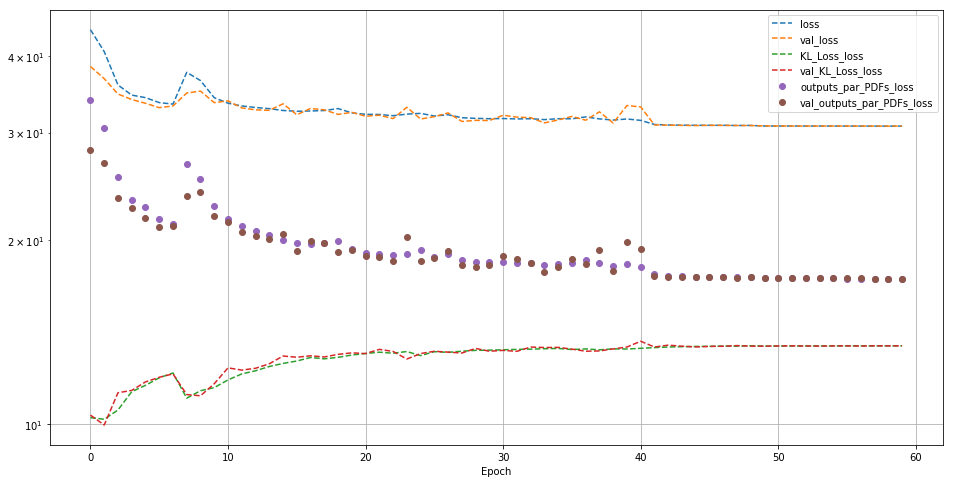

In [18]:
if do_training:
    f = plt.figure(figsize=(16,8))
    style = {'loss':'--', 'outputs_par_PDFs_loss': 'o', 'KL_Loss_loss': '--'}
    for item in style.keys():
        plt.plot(np.array(fit_report.history[item][:])[1:], style[item], label=item)
        plt.plot(np.array(fit_report.history['val_'+item][:])[1:], style[item], label='val_'+item)

    plt.xlabel('Epoch')
    plt.grid()
    plt.legend(loc='best')
    plt.yscale('log')

In [17]:
if do_training:
    vae.save('VAE_all-in-one_v4.h5')
else:
    from keras.models import load_model
    custom_objects = {
        'original_dim': x_train.shape[1],
        'latent_dim': latent_dim,
        'intermediate_dim': intermediate_dim,
        'act_fun': act_fun,
        'Nf_lognorm' : Nf_lognorm,
        'Nf_gauss' : Nf_gauss,
        'Nf_Pgauss' : Nf_Pgauss,
        'Nf_PDgauss' : Nf_PDgauss,
        'Nf_binomial' : Nf_binomial,
        'Nf_poisson' : Nf_poisson,
        'N_pseudo_inpusts' : N_pseudo_inpusts,
        'pseudo_inputs_init' : pseudo_inputs_init,
        'Pseudo_inputs_layer' : Pseudo_inputs_layer,
        'CustomKLLayer' : CustomKLLayer,
        'RecoProb_forVAE' : RecoProb_forVAE,
        'RecoLossVAE': RecoLossVAE,
        'IdentityLoss': IdentityLoss
    }
    
    vae = load_model('VAE_all-in-one_v4.h5', custom_objects=custom_objects)
    print 'Loaded'

TypeError: __init__() takes exactly 2 arguments (1 given)

### Build encoder and decoder

Get prior means and variance array

In [20]:
if do_training:
    Prior_Dumper = Model(inputs=x_DNN_input, outputs=[T_p_z_mean, T_p_z_sigma])
    Prior_Dumper.save('prior_all-in-one_v4.h5')
else:
    Prior_Dumper = load_model('prior_all-in-one_v4.h5', custom_objects=custom_objects)
    
aux = Prior_Dumper.predict(np.zeros((N_pseudo_inpusts, original_dim)), batch_size=N_pseudo_inpusts)
mu_prior = aux[0]
sigma_prior = aux[1]

# print mu_prior
# print sigma_prior

In [21]:
if do_training:
    encoder = Model(inputs=x_DNN_input, outputs=[T_z_mean, T_z_sigma])
    encoder.save('encoder_all-in-one_v4.h5')
else:
    encoder = load_model('encoder_all-in-one_v4.h5', custom_objects=custom_objects)

# Validation

Gather the signal data

In [22]:
x_sig = {}
for n in BSM_samples+TrainSamplesName:
    s = np.load(data_folder+n+'_lepFilter_13TeV_sample.npy')
    x_sig[n] = s[:N_train_max, sel]

### Predict latent space

In [23]:
x_train_encoded = np.array(encoder.predict(x_train, verbose=1, batch_size=2000))

x_sig_encoded = {}
for k,v in x_sig.iteritems():
    print k
    x_sig_encoded[k] = np.array(encoder.predict(v, verbose=1, batch_size=2000))

2577745/2577745 [==============================] - 1s 1us/step
Ato4l
47708/47708 [==============================] - 0s 1us/step
Wlnu
2000000/2000000 [==============================] - 1s 1us/step
Wprime
605662/605662 [==============================] - 0s 1us/step
qcd
1166195/1166195 [==============================] - 1s 1us/step
leptoquark
273604/273604 [==============================] - 0s 1us/step
Zprime
55362/55362 [==============================] - 0s 1us/step
ttbar
2000000/2000000 [==============================] - 1s 1us/step


Latent space mean distribution

Plotting dim 0 ...
	 Prior coverage: 0.961
	 SMMix coverage: 0.953
	 Ato4l coverage: 0.981
	 Wlnu coverage: 0.967
	 Wprime coverage: 0.953
	 qcd coverage: 0.926
	 leptoquark coverage: 0.975
	 Zprime coverage: 0.973
	 ttbar coverage: 0.989
Plotting dim 1 ...
	 Prior coverage: 1.000
	 SMMix coverage: 1.000
	 Ato4l coverage: 1.000
	 Wlnu coverage: 1.000
	 Wprime coverage: 1.000
	 qcd coverage: 1.000
	 leptoquark coverage: 1.000
	 Zprime coverage: 1.000
	 ttbar coverage: 1.000
Plotting dim 2 ...
	 Prior coverage: 0.969
	 SMMix coverage: 0.972
	 Ato4l coverage: 0.620
	 Wlnu coverage: 0.980
	 Wprime coverage: 0.980
	 qcd coverage: 0.958
	 leptoquark coverage: 0.867
	 Zprime coverage: 0.646
	 ttbar coverage: 0.846
Plotting dim 3 ...
	 Prior coverage: 0.980
	 SMMix coverage: 0.978
	 Ato4l coverage: 0.998
	 Wlnu coverage: 0.966
	 Wprime coverage: 0.974
	 qcd coverage: 1.000
	 leptoquark coverage: 0.994
	 Zprime coverage: 0.993
	 ttbar coverage: 0.960
Plotting dim 4 ...
	 Prior coverage: 1.281
	

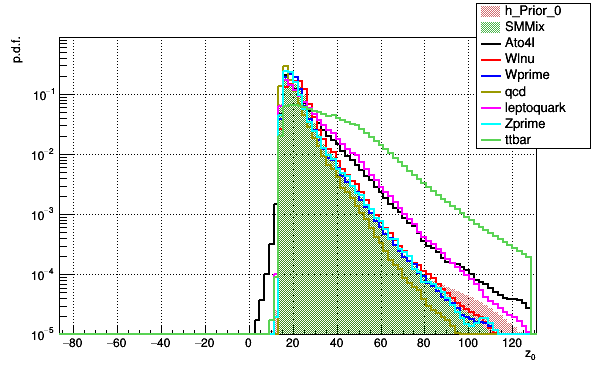

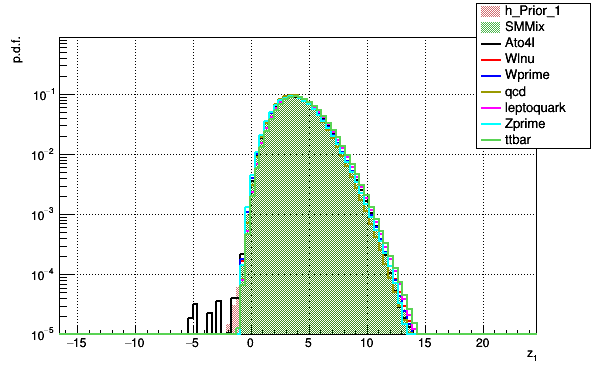

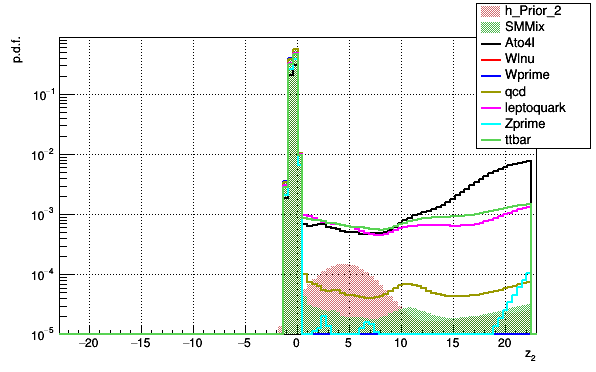

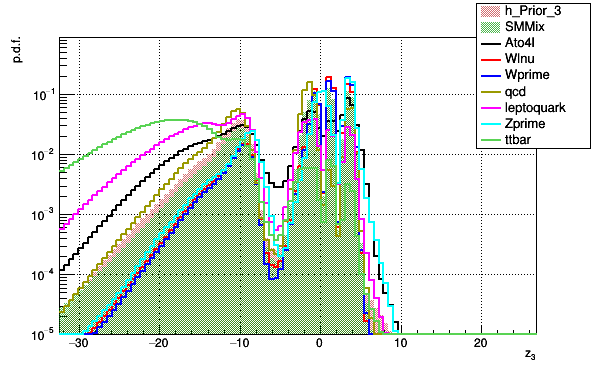

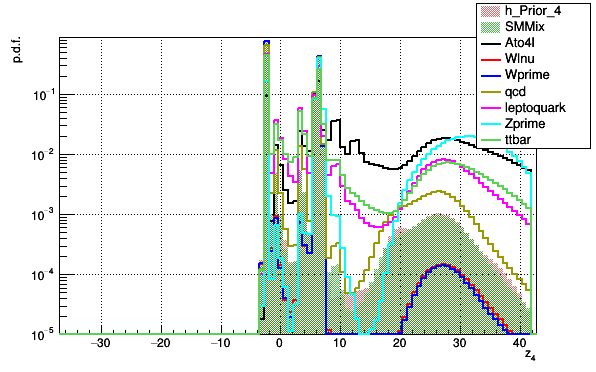

In [24]:
histos = []
canvases = []
N_bins = 100

for kk in range(latent_dim):
    print 'Plotting dim', kk, '...'
    canvas = rt.TCanvas('c'+str(kk), 'c'+str(kk), 600, 400)
    
    m_m = np.mean(mu_prior[:,kk])
    m_s = np.std(mu_prior[:,kk])
    
    s_m = np.mean(mu_prior[:,kk])
    s_s = np.std(mu_prior[:,kk])
    
    l_bound = m_m-3*(m_s+s_m+s_s)
    u_bound = m_m+3*(m_s+s_m+s_s)
    bin_width = (u_bound - l_bound)/(N_bins-1)
    z = np.arange(l_bound, u_bound, bin_width)
    
    bin_content = sum_of_gaussians(z, mu_prior[:,kk], sigma_prior[:,kk])*bin_width
    print '\t Prior coverage: {:.3f}'.format(np.sum(bin_content))
    h = rt.TH1F('h_Prior_{}'.format(kk), 'Prior', N_bins, l_bound-bin_width/2., u_bound+bin_width/2.)
    for i,c in enumerate(bin_content): 
        h.SetBinContent(i+1, c)
    h.SetStats(0)
    h.GetYaxis().SetRangeUser(1e-5, 0.9)
    h.SetLineWidth(0)
    h.SetFillColorAlpha(46, 0.9)
    h.SetFillStyle(3001)
    h.SetTitle('')
    h.SetXTitle('z_{'+str(kk)+'}')
    h.SetYTitle('p.d.f.')
    h.Draw('Bar')
    histos.append(h)
        
    bin_content = sum_of_gaussians(z, x_train_encoded[0, :, kk], x_train_encoded[1, :, kk])*bin_width
    print '\t SMMix coverage: {:.3f}'.format(np.sum(bin_content))
    h = rt.TH1F('h_SMMix_{}'.format(kk), 'SMMix', N_bins, l_bound-bin_width/2., u_bound+bin_width/2.)
    for i,c in enumerate(bin_content): 
        h.SetBinContent(i+1, c)
    h.SetStats(0)
    h.SetLineWidth(0)
    h.SetFillColorAlpha(rt.kGreen+2, 0.7)
    h.SetFillStyle(3001)
    h.Draw('Bar SAME')
    histos.append(h)


    colors = [1,2,4,rt.kYellow+2,6,7,8,46, 30, 40]
    for i, n in enumerate(x_sig.keys()):
        bin_content = sum_of_gaussians(z, x_sig_encoded[n][0, :, kk], x_sig_encoded[n][1, :, kk])*bin_width
        print '\t {} coverage: {:.3f}'.format(n, np.sum(bin_content))
        h = rt.TH1F('h_{}_{}'.format(n, kk), n, N_bins, l_bound-bin_width/2., u_bound+bin_width/2.)
        for j,c in enumerate(bin_content): 
            h.SetBinContent(j+1, c)

        h.SetStats(0)
        h.SetLineColor(colors[i])
        h.SetLineWidth(2)
        h.Draw('SAME')
        histos.append(h)

    canvas.BuildLegend(0.8, 0.6, 0.99, 0.99, '','lf')
    canvas.SetGrid()
    canvas.SetLogy()
    canvas.Draw()
    canvases.append(canvas)
    
fout = rt.TFile('plots/all-in-one_v4_meanZ.root', 'RECREATE')
for obj in canvases + histos:
    obj.Write()

fout.Close()

## Recostruction sum of pdf

In [25]:
if do_training:
    autoencoder = Model(inputs=x_DNN_input, outputs=[L_par1, L_par2, L_par3])
    autoencoder.save('autoencoder_all-in-one_v4.h5')
else:
    autoencoder = load_model('autoencoder_all-in-one_v4.h5', custom_objects=custom_objects)

In [26]:
pars_ae_train = autoencoder.predict(x_train, verbose=1, batch_size=2000)
# print pars_ae_train.shape

pars_ae_sig = {}
for k,v in x_sig.iteritems():
    print k
    pars_ae_sig[k] = autoencoder.predict(v, verbose=1, batch_size=2000)

2577745/2577745 [==============================] - 3s 1us/step
Ato4l
47708/47708 [==============================] - 0s 1us/step
Wlnu
2000000/2000000 [==============================] - 2s 1us/step
Wprime
605662/605662 [==============================] - 1s 1us/step
qcd
1166195/1166195 [==============================] - 1s 1us/step
leptoquark
273604/273604 [==============================] - 0s 1us/step
Zprime
55362/55362 [==============================] - 0s 1us/step
ttbar
2000000/2000000 [==============================] - 2s 1us/step


HT
allJetMass
allMuPt
allMuMass
allElePt
allEleMass
LepPt
LepIsoCh
LepIsoGamma
LepIsoNeu
METp
METo
MT
nMu
nJets
bJets
nEle
LepCharge
LepIsEle
nChHad
nNeuHad


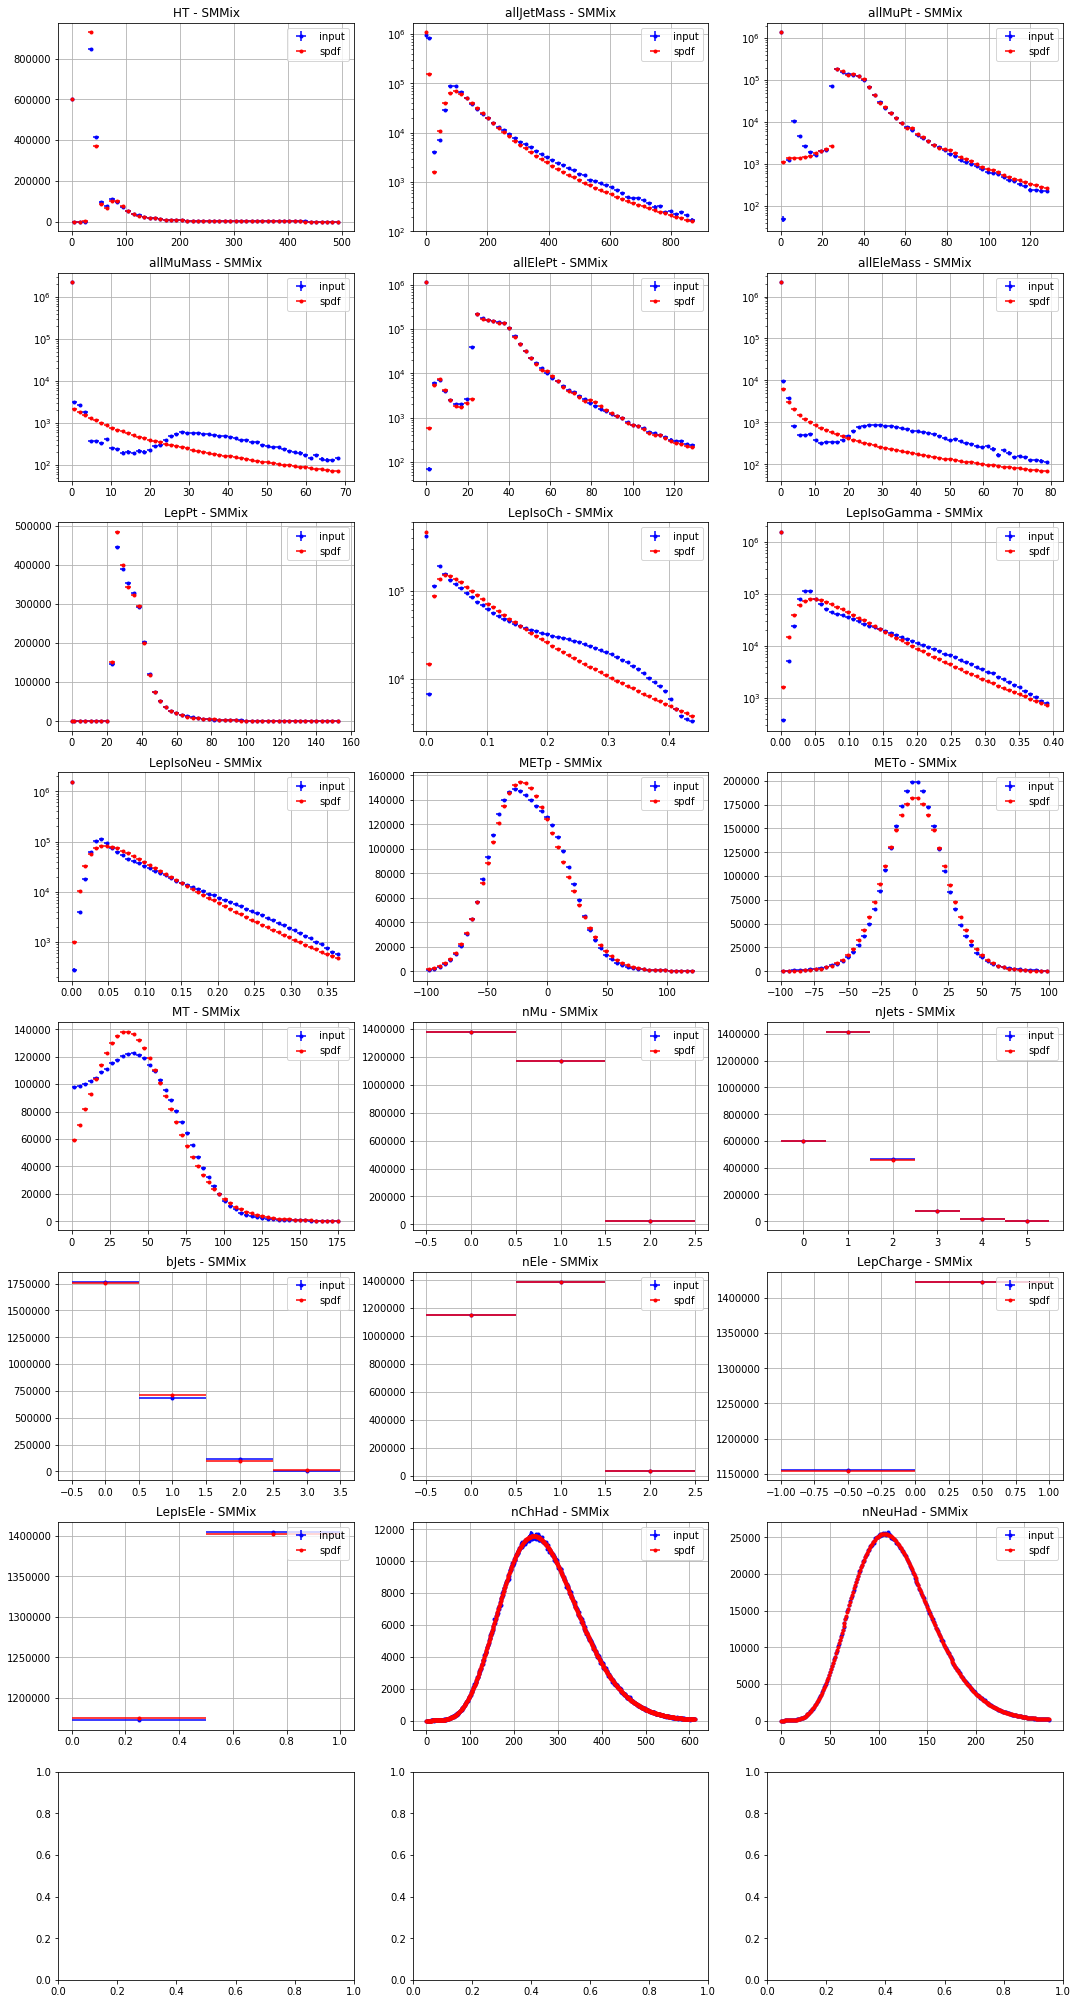

In [27]:
f, ax_arr = plt.subplots(1+int(len(active_hlf_features)/3.),3 , figsize=(18,36))
N_bins = 50
for i,hlf_name in enumerate(active_hlf_features):
    print hlf_name
#     plt.yscale('log', nonposy='clip')
    
    #Plot distribution of the variable
    x_aux = x_train[:, i]
    if i < Nf_lognorm:
        histo_range = (0, np.percentile(x_aux, 99.9))
        bin_content, bin_edges = np.histogram(x_aux, bins=N_bins, range=histo_range)
        if np.sum(bin_edges>clip_x_to0) > 0:
            i_aux = np.argmin(bin_edges<clip_x_to0)
            bin_edges = np.concatenate((np.array([0, clip_x_to0]), bin_edges[i_aux:]))
        else:
            bin_edges = np.array([0, clip_x_to0])
        bin_content, bin_edges = np.histogram(x_aux, bins=bin_edges, range=histo_range)
        bincenters = 0.5*(bin_edges[1:]+bin_edges[:-1])
        bin_width = bin_edges[1:] - bin_edges[:-1]
        bin_width[0] = 1.

        mu_vec = pars_ae_train[0][:, i]
        sigma_vec = pars_ae_train[1][:, i]
        f_vec = pars_ae_train[2][:, i]
        spdf_bin_content = np.sum(bin_content)*bin_width*sum_of_lognorm(bincenters, f_vec, mu_vec, sigma_vec)
    elif i < Nf_lognorm + Nf_gauss:
        histo_range = (np.percentile(x_aux, .1), np.percentile(x_aux, 99.9))
        bin_content, bin_edges = np.histogram(x_aux, bins=N_bins, range=histo_range)
        bincenters = 0.5*(bin_edges[1:]+bin_edges[:-1])
        bin_width = bincenters[1]-bincenters[0]

        mu_vec = pars_ae_train[0][:, i]
        sigma_vec = pars_ae_train[1][:, i]
        spdf_bin_content = np.sum(bin_content)*bin_width*sum_of_gaussians(bincenters, mu_vec, sigma_vec)
    elif i < Nf_lognorm + Nf_gauss + Nf_Pgauss:
        histo_range = (np.percentile(x_aux, .1), np.percentile(x_aux, 99.9))
        bin_content, bin_edges = np.histogram(x_aux, bins=N_bins, range=histo_range)
        bincenters = 0.5*(bin_edges[1:]+bin_edges[:-1])
        bin_width = bincenters[1]-bincenters[0]

        mu_vec = pars_ae_train[0][:, i]
        sigma_vec = pars_ae_train[1][:, i]
        spdf_bin_content = np.sum(bin_content)*bin_width*sum_of_Pgauss(bincenters, mu_vec, sigma_vec)
    elif i < Nf_lognorm + Nf_gauss + Nf_Pgauss + Nf_PDgauss:
        Nmax = int(np.percentile(x_aux, 99.9))
        bin_content, bin_edges = np.histogram(x_aux, bins=Nmax+1, range=(-0.5, Nmax+0.5))
        bincenters = 0.5*(bin_edges[1:]+bin_edges[:-1])
        bin_width = bincenters[1]-bincenters[0]

        mu_vec = pars_ae_train[0][:, i]
        sigma_vec = pars_ae_train[1][:, i]
        spdf_bin_content = np.sum(bin_content)*bin_width*sum_of_PDgauss(bincenters, mu_vec, sigma_vec)
    elif i < Nf_lognorm + Nf_gauss + Nf_Pgauss + Nf_PDgauss + Nf_binomial:
        bin_content, bin_edges = np.histogram(x_aux, bins=2, range=(np.min(x_aux), np.max(x_aux)))
        bincenters = 0.5*(bin_edges[1:]+bin_edges[:-1])
        bin_width = bincenters[1]-bincenters[0]
        p = 0.5*(1+0.98*np.tanh(pars_ae_train[0][:, i]))

        spdf_bin_content = np.zeros_like(bincenters)
        spdf_bin_content[np.nonzero(bin_content)[0][1]] = np.sum(p)
        spdf_bin_content[np.nonzero(bin_content)[0][0]] = np.sum(1-p)
    else:
        Nmax = int(np.percentile(x_aux, 99.9))
        bin_content, bin_edges = np.histogram(x_aux, bins=Nmax+1, range=(-0.5, Nmax+0.5))
        bincenters = 0.5*(bin_edges[1:]+bin_edges[:-1])
        bin_width = bincenters[1]-bincenters[0]
        aux = pars_ae_train[0][:, i]
        mu_vec = 1 + np.where(np.greater(aux, 0), aux, np.divide(aux, np.sqrt(1+np.square(aux))))
        spdf_bin_content = sum_of_possion(bincenters, mu_vec)


    if i < Nf_lognorm:
        bin_width[0] = clip_x_to0
        
    ax_arr[i/3, i%3].errorbar(bincenters, bin_content, xerr=bin_width/2., yerr=np.sqrt(bin_content), fmt='.b', label='input')
    ax_arr[i/3, i%3].errorbar(bincenters, spdf_bin_content, xerr=bin_width/2., fmt='.r', label='spdf')
    ax_arr[i/3, i%3].grid()
    ax_arr[i/3, i%3].set_title(hlf_name + ' - SMMix')        
    ax_arr[i/3, i%3].legend(loc='best')
    
    if hlf_name.startswith('LepIso') or hlf_name.startswith('all'):
        ax_arr[i/3, i%3].set_yscale('log')
        
plt.show()

# Test Statistics with Losses

In [28]:
class CustomRecoProbLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomRecoProbLayer, self).__init__(**kwargs)

    def call(self, inputs):
        x, par1, par2, par3 = inputs    
        return RecoProb_forVAE(x, par1, par2, par3)

L_RecoProb = CustomRecoProbLayer(name='RecoProb')([x_DNN_input, L_par1, L_par2, L_par3])

NNLoss = Model(inputs=x_DNN_input, outputs=[L_KL_loss, L_RecoProb])

if do_training:
    NNLoss.save('NNLoss_all-in-one_v4.h5')
else:
    NNLoss = load_model('NNLoss_all-in-one_v4.h5', custom_objects=custom_objects)

In [29]:
print 'SMMix'
out = NNLoss.predict(x_train, verbose=1, batch_size=2000)
loss_train = np.column_stack((out[0]+out[1], out[1], out[0])).T

loss_sig = {}
for n in x_sig.keys():
    print n
    aux = NNLoss.predict(x_sig[n], verbose=1, batch_size=2000)
    loss_sig[n] = np.column_stack((aux[0]+aux[1], aux[1], aux[0])).T

SMMix
2577745/2577745 [==============================] - 235s 91us/step
Ato4l
47708/47708 [==============================] - 4s 91us/step
Wlnu
2000000/2000000 [==============================] - 182s 91us/step
Wprime
605662/605662 [==============================] - 56s 92us/step
qcd
1166195/1166195 [==============================] - 108s 92us/step
leptoquark
273604/273604 [==============================] - 25s 91us/step
Zprime
55362/55362 [==============================] - 5s 90us/step
ttbar
2000000/2000000 [==============================] - 182s 91us/step


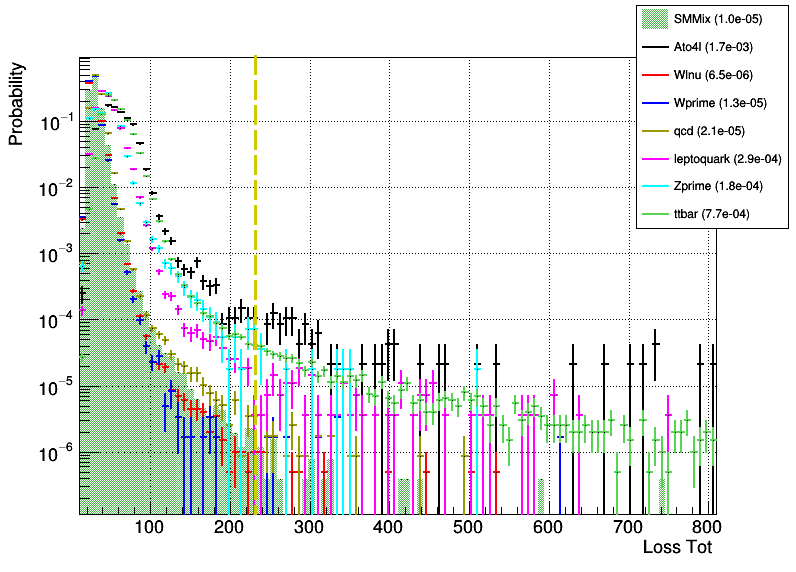

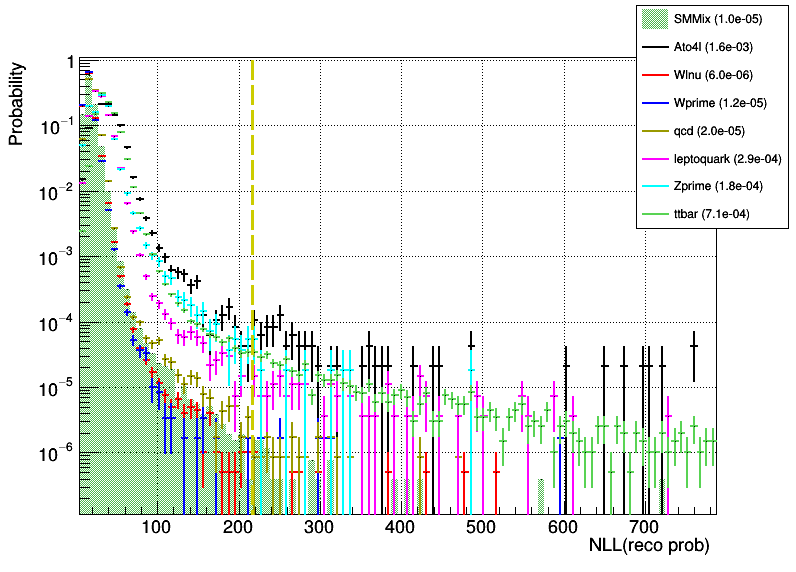

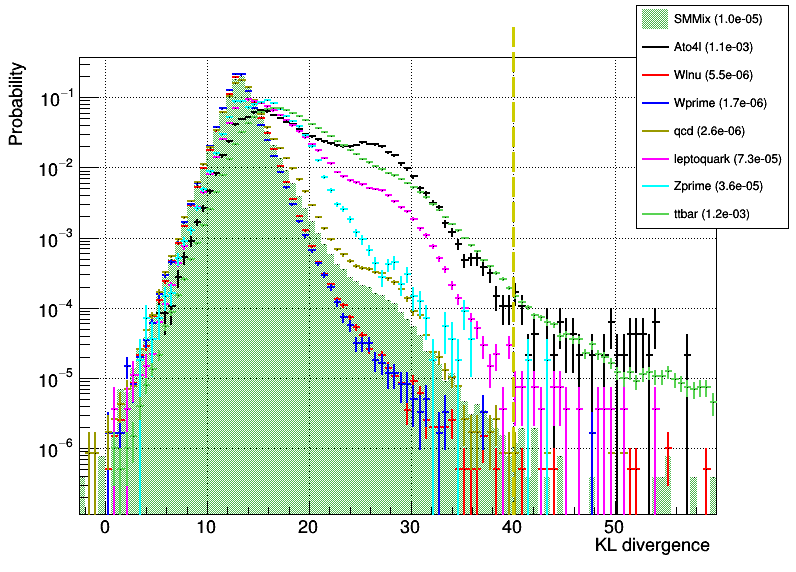

In [30]:
histos = []
canvases = []
Ytitles = ['Loss Tot', 'NLL(reco prob)', 'KL divergence']

eff_SMMix = 1e-5

for loss_piece in range(3):
    binning = [100, np.min(loss_train[loss_piece]), np.percentile(loss_train[loss_piece], 100*(1-1e-6))]
    c = rt.TCanvas('c'+str(loss_piece), 'c'+str(loss_piece), 800, 600)

    h = rt.TH1F('h_loss_SMMix_{}'.format(loss_piece), 'SMMix', binning[0], binning[1], binning[2])
    rtnp.fill_hist(h, loss_train[loss_piece])
    h.Scale(1./loss_train[loss_piece].shape[0])
    h.SetStats(0)
    h.SetLineWidth(0)
    h.SetFillColorAlpha(rt.kGreen+2, 0.7)
    h.SetFillStyle(3001)
    h.Draw('Bar SAME')
    histos.append(h)

    val_to_cut = np.percentile(loss_train[loss_piece], 100*(1-eff_SMMix))
    h.SetTitle(h.GetTitle()+' ({:1.1e})'.format(eff_SMMix))


    colors = [1,2,4,rt.kYellow+2,6,7,8,46, 30, 40]
    for i, n in enumerate(x_sig.keys()):
        z = loss_sig[n][loss_piece]
        eff = np.sum(z>val_to_cut)/float(z.shape[0])
        h1 = rt.TH1F('h_loss_{}_{}'.format(n, loss_piece), n+' ({:1.1e})'.format(eff), binning[0], binning[1], binning[2])
        rtnp.fill_hist(h1, z)
        h1.Scale(1./float(z.shape[0]))

        h1.SetStats(0)
        h1.SetLineColor(colors[i])
        h1.SetLineWidth(2)
        h1.Draw('SAME')
        histos.append(h1)

    c.BuildLegend(0.8, 0.6, 0.99, 0.99, '','lf')
    h.SetTitle('')
    h.SetXTitle(Ytitles[loss_piece])
    h.SetYTitle('Probability')

    line = rt.TLine()
    line.SetLineColor(rt.kYellow+1)
    line.SetLineWidth(3)
    line.SetLineStyle(9)
    line.DrawLine(val_to_cut,0, val_to_cut,1)

    c.SetGrid()
    c.SetLogy()
    c.Draw()
    canvases.append(c)
    
fout = rt.TFile('plots/all-in-one_v4_losses.root', 'RECREATE')
for obj in canvases + histos:
    obj.Write()

fout.Close()



In [31]:
# import h5py

# fout = h5py.File('losses/all-in-one_v3.1.h5', "w")
# fout.create_dataset('SM_train_mixture', data=np.array(loss_train))
# for k,v in loss_sig.items():
#     fout.create_dataset(k, data=np.array(v))
# fout.close()

In [33]:
SM_evts_per_month = 5000

trigger_rate_dic = {'Wlnu':440. ,'qcd':251., 'ttbar':2.5} #Hz
acquisition_sec_per_year = 1e7
lumi_per_yr = 50 #fb^-1

eff_SMMix = SM_evts_per_month/(np.sum(trigger_rate_dic.values()) * acquisition_sec_per_year / 12.)
print 'Eff SM --->> {:.2e}\n\n\n'.format(eff_SMMix)

for ll in range(3):
    cut = np.percentile(loss_train[ll], 100*(1-eff_SMMix))
    
    print '----------------',Ytitles[ll], '----------------'
    table_SM = PrettyTable(['Sample', 'Efficiency','Rate [mHz]', 'evts/month'])
    table_BSM = PrettyTable(['Sample', 'Efficiency', 'xsec (100 evts/month) [fb]', 'xsec (S/B = 0.3) [fb]'])
    
    N_tot = np.sum(loss_train[ll] > cut)
    d_N_tot = np.sqrt(loss_train[ll].shape[0]*(1-eff_SMMix)*eff_SMMix)
    
    for n, lss in loss_sig.items():
        aux = np.greater(lss[ll,:], cut)
        selected = np.sum(aux)
        eff = float(selected)/lss.shape[1]
        d_eff = np.sqrt(eff*(1-eff)/lss.shape[1])
        
        if n in ['qcd', 'Wlnu', 'ttbar']:
            rate = trigger_rate_dic[n]*eff
            N_evts = rate*acquisition_sec_per_year/12.
            d_N_evts = trigger_rate_dic[n]*d_eff*acquisition_sec_per_year/12.
            table_SM.add_row([n, '{:1.1e} +/- {:1.1e}'.format(eff, d_eff), '{:.1f}'.format(1000*rate), '{:.0f} +/- {:.0f}'.format(N_evts, d_N_evts)])
        else:
            if eff == 0:
                print n, eff
                continue
            x_sec_lim = 100. * 12/ (lumi_per_yr * eff)
            x_sec_SoB = 0.3*N_tot*12/ (lumi_per_yr * eff)
            table_BSM.add_row([n, '{:1.1e} +/- {:1.1e}'.format(eff, d_eff), '{:.1f}'.format(x_sec_lim), '{:1.1e}'.format(x_sec_SoB)])


    print table_SM
    print 'Expected evts/month: {:.0f} +/- {:.0f}'.format(N_tot, d_N_tot)
    print table_BSM
    print '\n\n'

Eff SM --->> 8.65e-06



---------------- Loss Tot ----------------
+--------+---------------------+------------+--------------+
| Sample |      Efficiency     | Rate [mHz] |  evts/month  |
+--------+---------------------+------------+--------------+
|  Wlnu  | 6.0e-06 +/- 1.7e-06 |    2.6     | 2200 +/- 635 |
|  qcd   | 1.9e-05 +/- 4.0e-06 |    4.7     | 3946 +/- 841 |
| ttbar  | 7.6e-04 +/- 1.9e-05 |    1.9     | 1578 +/- 41  |
+--------+---------------------+------------+--------------+
Expected evts/month: 23 +/- 5
+------------+---------------------+----------------------------+-----------------------+
|   Sample   |      Efficiency     | xsec (100 evts/month) [fb] | xsec (S/B = 0.3) [fb] |
+------------+---------------------+----------------------------+-----------------------+
|   Ato4l    | 1.7e-03 +/- 1.9e-04 |          14312.4           |        9.9e+02        |
|   Wprime   | 1.3e-05 +/- 4.7e-06 |         1816986.0          |        1.3e+05        |
| leptoquark | 2.9e-04 +/